# ALBERT with Fastai - SquAD Scratch

In [1]:
from fastai.text import *
from fastai.metrics import *
import torch

from transformers import AlbertForQuestionAnswering, AlbertTokenizer
import jsonlines

In [2]:
# defining utility functions

def str2tensor(s,adj):
    indices = re.findall("\d+",s)
    return torch.tensor([int(indices[0])+adj, int(indices[1])+adj], dtype=torch.long)

# Creating a config class to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

In [3]:
# defining our configuration
config = Config(
    task = "SQuAD",
    testing=False,
    seed = 2019,
    bert_model_name='albert-base-v2', # can also be exchanged with bert-large 
    pad_idx = 0,
    max_lr=5e-5,
    epochs=1,
    use_fp16=False,
    bs=4, 
    max_seq_len=384,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for bert-large
    start_tok = "[CLS]",
    end_tok = "[SEP]",
    mark_fields=True,
    feat_cols = ["paragraph","question"],
    label_cols = "idxs",
    adjustment = 1
)

In [4]:
# setting our data directory
path = Path("../../")
data_path = path/"data/SQuAD/1.1/"

## Loading from CSV

In [5]:
# Load Data
train = pd.read_csv(data_path/"train_albert.csv")
val = pd.read_csv(data_path/"val_albert.csv")

In [6]:
# reduce df sizes if testing
if config.testing:
    train = train[:10000]
    val = val[:2000]

In [7]:
# dropping any rows with na values
train.dropna(inplace=True)
val.dropna(inplace=True)

In [8]:
def remove_max_sl(df):
    init_len = len(df)
    df = df[df.seq_len < config.max_seq_len-2]
    new_len = len(df)
    print(f"dropping {init_len - new_len} out of {init_len} questions")
    return df

In [9]:
train, val = remove_max_sl(train), remove_max_sl(val)

dropping 998 out of 87599 questions
dropping 643 out of 34726 questions


In [10]:
# randomizing the order of training data
train = train.sample(frac=1,random_state = config.seed).reset_index(drop=True)
val = val.sample(frac=1, random_state = config.seed).reset_index(drop=True)

## Setting Up the Tokenizer

In [11]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: AlbertTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Bert bos and eos tokens and limits the maximum sequence length""" 
        if config.mark_fields:
            sub = 2 # subtraction in totoal seq_length to be made due to adding spcl tokens
            assert "xxfld" in t
            t = t.replace("xxfld 1","") # remove the xxfld 1 special token from fastai
            # converting fastai field sep token to Bert
            t = re.split(r'xxfld \d+', t) 
            res = []
            for i in range(len(t)-1): # loop over the number of additional fields and the Bert sep
                res += self._pretrained_tokenizer.tokenize(t[i]) + [config.end_tok]
                sub += 2 # increase our subtractions since we added more spcl tokens
            res += self._pretrained_tokenizer.tokenize(t[-1]) # add the last sequence
            return [config.start_tok] + res[:self.max_seq_len - sub] + [config.end_tok] 
        
        res = self._pretrained_tokenizer.tokenize(t)
        return [config.start_tok] + res[:self.max_seq_len - sub] + [config.end_tok]

In [12]:
# create fastai tokenizer for bert
bert_tok = AlbertTokenizer.from_pretrained(config.bert_model_name)

fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

fastai_bert_vocab = Vocab([bert_tok.convert_ids_to_tokens(i) for i in range(bert_tok.vocab_size)])

In [13]:
# Setting up pre-processors
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False, mark_fields=config.mark_fields)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_bert_vocab, **kwargs)


def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Bert
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Bert model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

## Setting up the DataBunch

In [14]:
def pad_collate_qa(samples:BatchSamples, pad_idx:int=config.pad_idx, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len = max([len(s[0]) for s in samples])
    res_x = torch.zeros(len(samples), max_len).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: res_x[i,-len(s[0]):] = LongTensor(s[0])
        else:         res_x[i,:len(s[0]):] = LongTensor(s[0])
    if backwards: res_x = res_x.flip(1)
    res_y = torch.stack([s[1] for s in samples])
    return res_x, res_y

In [15]:
# Creating a Bert specific DataBunch class
class BertDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Bert"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate_qa, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

In [16]:
# Creating a class for Bert Text Lists
class BertTextList(TextList):
    _bunch = BertDataBunch
    _label_cls = TextList

In [17]:
# Creating a special class for QA labels 
class QAItemList(ItemList):    
    def get(self, i):
        f = super().get(i)
        return str2tensor(f,adj=config.adjustment)

In [18]:
# loading the tokenizer and vocab processors
processor = get_bert_processor(tokenizer=fastai_tokenizer, vocab=fastai_bert_vocab)

# creating our databunch 
data = ItemLists(".", BertTextList.from_df(train, ".", cols=config.feat_cols, processor=processor),
                      BertTextList.from_df(val, ".", cols=config.feat_cols, processor=processor)
                ) \
       .label_from_df(cols=config.label_cols, label_cls=QAItemList) \
       .databunch(bs=config.bs,pad_first=False)

## Building the Model

In [19]:
# CustomBertModel
class CustomBertModel(nn.Module):
    def __init__(self):
        super(CustomBertModel,self).__init__()
        self.bert = AlbertForQuestionAnswering.from_pretrained(config.bert_model_name)
        self.bert.train()
        
    def forward(self, input_ids,token_type_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids)
        return outputs

In [20]:
# defining the loss function
def cross_entropy_qa(input, target):
    """
    Summing the cross entropy loss from the starting and ending indices. 
    """
    loss = torch.add(F.cross_entropy(input[0], target[:,0]) , F.cross_entropy(input[1], target[:,1]))
    return loss 

In [21]:
# defining the evaluation metric
def acc_qa(input,target):
    """
    Taking the average between the accuracies of predicting the start and ending indices
    """
    return (accuracy(input[0], target[:,0]) + accuracy(input[1], target[:,1]))/2

In [22]:
bert_model = CustomBertModel()

In [23]:
learn = Learner(data, bert_model, loss_func=cross_entropy_qa, metrics=acc_qa)

In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


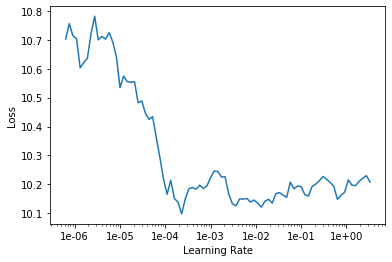

In [26]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, max_lr=config.max_lr)

epoch,train_loss,valid_loss,acc_qa,time


In [100]:
# save model
st = learn.model.state_dict()
torch.save(st,"albert-68.pth")

In [ ]:
def get_preds(model:nn.Module, dl:DataLoader, pbar:Optional[PBar]=None, cb_handler:Optional[CallbackHandler]=None,
    activ:nn.Module=None, loss_func:OptLossFunc=None, n_batch:Optional[int]=None) -> List[Tensor]:
    "Tuple of predictions and targets, and optional losses (if `loss_func`) using `dl`, max batches `n_batch`."
    
    
    res = []
    for o in zip(*validate(model, dl, cb_handler=cb_handler, pbar=pbar, average=False, n_batch=n_batch)):
        res.append(o)
    return res

In [98]:
# preds = get_preds(learn.model,data.valid_dl)

print(f"val accuracy is {np.mean([acc_qa(preds[0][i],preds[1][i]) for i in range(len(preds[0]))])}")

# train_preds = get_preds(learn.model,data.train_dl)

print(f"train accuracy is {np.mean([acc_qa(train_preds[0][i],train_preds[1][i]) for i in range(len(train_preds[0]))])}")


val accuracy is 0.6860648393630981
train accuracy is 0.7335623502731323


In [95]:
train_preds = get_preds(learn.model,data.train_dl)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [97]:
print(f"train accuracy is {np.mean([acc_qa(train_preds[0][i],train_preds[1][i]) for i in range(len(train_preds[0]))])}")


train accuracy is 0.7335623502731323


# Scratch

In [ ]:
# tests

def check_sl(idx):
    seq_len = len(bert_tok.tokenize(train.loc[idx].paragraph + train.loc[idx].question))
    match = seq_len == train.loc[idx].seq_len
    if not match:
        print(seq_len,train.loc[idx])
    return match
    
# [check_sl(i) for i in range(100)]

In [ ]:
# previewing the data

def preview(idx):
    print(str(data.x[idx]).split("[SEP]")[1])
    ans_idx = data.x[idx].data[data.y[idx][0]:data.y[idx][1]]
    print(bert_tok.decode(ans_idx))


data.x[0].data[data.y[0][0]:data.y[0][1]]


for i in range(100):
    preview(i)
    print("\n")